In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50 ,DenseNet121, EfficientNetB7,VGG16
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam ,RMSprop
from keras.callbacks import ModelCheckpoint , ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [2]:
df = pd.read_csv('COVID-19_Radiography_Dataset.csv')
df["category"] = df["category"].replace({0: 'Normal', 1: 'COVID-19', 2: 'Viral Pneumonia'})

In [3]:
df['category'].value_counts()

category
COVID-19           10848
Normal             10192
Viral Pneumonia     5380
Name: count, dtype: int64

<Axes: xlabel='category'>

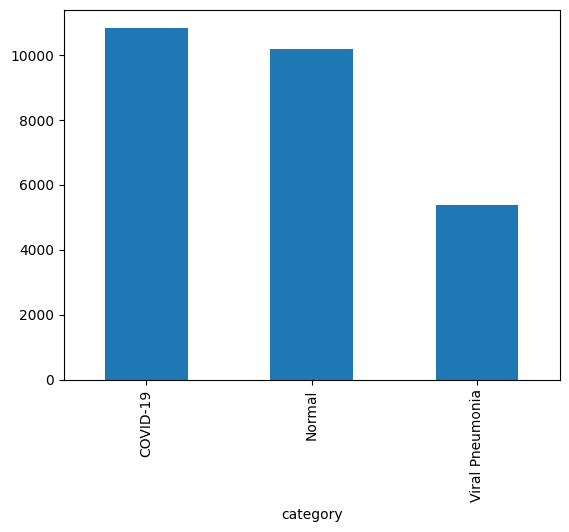

In [4]:
df['category'].value_counts().plot.bar()

In [5]:
class_counts = df['category'].value_counts()
class_counts

category
COVID-19           10848
Normal             10192
Viral Pneumonia     5380
Name: count, dtype: int64

In [6]:
from imblearn.over_sampling import RandomOverSampler

# Oversample the minority classes to match the count of the majority class ('COVID-19')
oversample = RandomOverSampler(sampling_strategy={'Normal': class_counts['COVID-19'],
                                                  'Viral Pneumonia': class_counts['COVID-19']})
X_resampled, y_resampled = oversample.fit_resample(df.drop(columns=['category']), df['category'])

# Combine the resampled data into a DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=df.columns.drop('category'))
df_resampled['category'] = y_resampled

# Check the class distribution after oversampling
print(df_resampled['category'].value_counts())


category
Viral Pneumonia    10848
COVID-19           10848
Normal             10848
Name: count, dtype: int64


In [9]:
df_resampled = df_resampled.sample(frac=1).reset_index(drop=True)

In [10]:
# Divide the dataset into training and validation sets
train_df, val_df = train_test_split(df_resampled, test_size=0.20, random_state=42)
validate_df,test_df = train_test_split(val_df, test_size=0.50, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [11]:
# Set your IMAGE_SIZE and other parameters
IMAGE_SIZE = (180,180)
batch_size = 16

In [12]:
#Create data generators
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
# train_datagen = ImageDataGenerator(
#     rotation_range=15,
#     rescale=1./255,
#     shear_range=0.1,
#     # zoom_range=0.2,
#     horizontal_flip=True,
    
#     brightness_range=[0.5, 1.5],
#     channel_shift_range=0.2,
#     vertical_flip=True,
#     preprocessing_function=lambda x: x + 0.01 * np.random.randn(*x.shape),
#     # random_rotation=30,
#     height_shift_range=0.1,
#     width_shift_range=0.1,
#     zoom_range=[0.8, 1.2],
#     # Exclude unsupported parameter
# )

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    directory=None,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
      batch_size=batch_size
)
   

Found 26035 validated image filenames belonging to 3 classes.
Found 3254 validated image filenames belonging to 3 classes.


In [13]:
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, reduction=tf.keras.losses.Reduction.AUTO, name="custom_loss"):
        super().__init__(reduction=reduction, name=name)

    def call(self, y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred))

In [14]:
custom_loss = CustomLoss()

In [15]:
previous_model = load_model('pneumonia_ds.h5',custom_objects={'CustomLoss': CustomLoss})

In [16]:
# Remove the last dense layer
previous_model.layers.pop()

# Add a new dense layer with the appropriate number of units for the new classification task
num_classes = 3  # Assuming you have three classes in the new dataset
new_classification_layer = Dense(num_classes, activation='softmax', name='new_classification')(previous_model.layers[-1].output)

# Create a new model with the modified architecture
model = Model(inputs=previous_model.input, outputs=new_classification_layer)

# Compile the model with the new configuration
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
model.compile(optimizer=Adam(lr=0.001), loss=custom_loss, metrics=['accuracy'])

c:\Users\Iftek\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        9248      
                                                             

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'accuracy', 
                                            patience = 2, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.000001)
earlystop = EarlyStopping(
    monitor='val_loss',  # You can change this to another metric like 'val_accuracy'
    patience=10,  # Wait for 10 epochs to see if overfitting is resolved
    restore_best_weights=True,
    verbose=1
)
callbacks = [earlystop, learning_rate_reduction]



In [20]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [21]:
# Fit the model
epochs = 100

# history = model.fit_generator(
#     train_generator,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=total_validate // batch_size,
#     steps_per_epoch=total_train // batch_size,
#     callbacks=callbacks
# )
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks=callbacks
)

Epoch 1/100
1627/1627 [==============================] - 269s 161ms/step - loss: 0.1630 - accuracy: 0.6852 - val_loss: 0.1766 - val_accuracy: 0.5696 - lr: 0.0010
Epoch 2/100
1627/1627 [==============================] - 249s 153ms/step - loss: 0.1313 - accuracy: 0.7396 - val_loss: 0.1215 - val_accuracy: 0.7528 - lr: 0.0010
Epoch 3/100
1627/1627 [==============================] - 294s 181ms/step - loss: 0.1174 - accuracy: 0.7679 - val_loss: 0.0872 - val_accuracy: 0.8473 - lr: 0.0010
Epoch 4/100
1627/1627 [==============================] - 267s 164ms/step - loss: 0.0946 - accuracy: 0.8184 - val_loss: 0.0993 - val_accuracy: 0.8011 - lr: 0.0010
Epoch 5/100
1627/1627 [==============================] - 263s 162ms/step - loss: 0.0877 - accuracy: 0.8305 - val_loss: 0.0844 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 6/100
1627/1627 [==============================] - 258s 158ms/step - loss: 0.0785 - accuracy: 0.8490 - val_loss: 0.1013 - val_accuracy: 0.7771 - lr: 0.0010
Epoch 7/100
1627/1627 [=====

In [22]:
model.save('radiography_ds.h5')

In [23]:
actual_epochs = len(history.history['loss'])

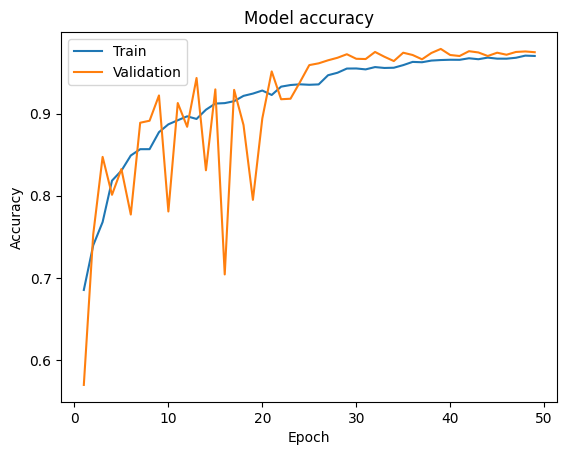

In [24]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
numEpochs = range(1,  actual_epochs + 1)
plt.plot(numEpochs,history.history['accuracy'])
plt.plot(numEpochs,history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

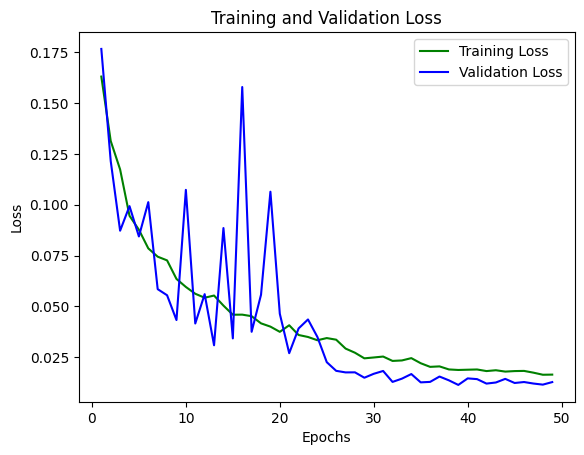

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
numEpochs = range(1,  actual_epochs + 1)
plt.plot( numEpochs,loss, 'g', label='Training Loss')
plt.plot(numEpochs,val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df

,filename,category
0,Datasets\COVID-19_Radiography_Dataset\Normal\i...,Normal
1,Datasets\COVID-19_Radiography_Dataset\Viral Pn...,Viral Pneumonia
2,CL+MEDIAN\COVID-19_Radiography_Dataset\Viral P...,Viral Pneumonia
3,CL+MEDIAN\COVID-19_Radiography_Dataset\COVID\i...,COVID-19
4,Datasets\COVID-19_Radiography_Dataset\COVID\im...,COVID-19
...,...,...
3250,CL+MEDIAN\COVID-19_Radiography_Dataset\COVID\i...,COVID-19
3251,CL+MEDIAN\COVID-19_Radiography_Dataset\Viral P...,Viral Pneumonia
3252,Datasets\COVID-19_Radiography_Dataset\Normal\i...,Normal
3253,CL+MEDIAN\COVID-19_Radiography_Dataset\Viral P...,Viral Pneumonia


In [27]:
nb_samples = test_df.shape[0]

In [28]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(    
    test_df, 
    directory=None,
    x_col='filename',
    y_col='category',
    target_size = IMAGE_SIZE,
    
    class_mode='categorical',
    batch_size = batch_size,
    shuffle = False,
)

Found 3255 validated image filenames belonging to 3 classes.


In [29]:
import numpy as np

In [30]:
predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))

C:\Users\Iftek\AppData\Local\Temp\ipykernel_13604\2670138283.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))


In [31]:
test_df['predict_category'] = np.argmax(predict, axis=-1)

In [32]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['predict_category'] = test_df['predict_category'].replace(label_map)

In [33]:
test_df['predict_category'] = test_df['predict_category'].replace({'Normal': 0, 'COVID-19': 1, 'Viral Pneumonia': 2})

<Axes: xlabel='category'>

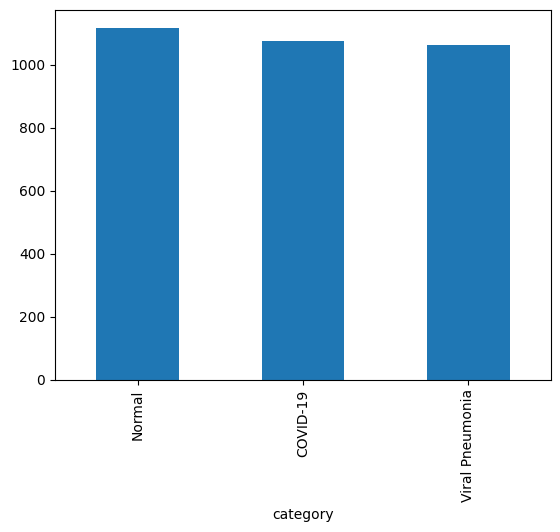

In [34]:
test_df['category'].value_counts().plot.bar()

In [35]:
sample_test = test_df
correctPredictions = 0

correctNormalPred = 0
correctCovidPred = 0
correctPneuPred = 0

totalNormalPred = 0
totalCovidPred = 0
totalPneuPred = 0

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    prediction = row['predict_category']
    
    # img = load_img(filename, target_size=IMAGE_SIZE)
    path_parts = filename.split('\\')
    third_phrase = path_parts[2]
    # print(third_phrase)

    if 'Normal' in third_phrase:
        
        if prediction == 0:
            correctPredictions += 1
            correctNormalPred += 1
            
        totalNormalPred += 1
    
    if 'COVID' in third_phrase:
        
        if prediction == 1: 
            correctPredictions += 1
            correctCovidPred += 1
            
        totalCovidPred += 1
    
    if 'Viral Pneumonia' in third_phrase:
        
        if prediction == 2: 
            correctPredictions += 1
            correctPneuPred += 1
            
        totalPneuPred += 1
    

In [36]:
print('Model Accuracy:', "{:.2%}".format(correctPredictions / test_df.shape[0]))
print('Correct Predictions:', correctPredictions, 'Total Predictions:', test_df.shape[0])

print('\nNormal Predictions:', correctNormalPred, 'Accuracy', "{:.2%}".format(correctNormalPred /  totalNormalPred))
print('COVID-19 Predictions:', correctCovidPred, 'Accuracy', "{:.2%}".format(correctCovidPred /  totalCovidPred))
print('Viral Pneumonia Predictions:', correctPneuPred, 'Accuracy', "{:.2%}".format(correctPneuPred / totalPneuPred))

Model Accuracy: 97.73%
Correct Predictions: 3181 Total Predictions: 3255

Normal Predictions: 1100 Accuracy 98.39%
COVID-19 Predictions: 1039 Accuracy 96.74%
Viral Pneumonia Predictions: 1042 Accuracy 98.02%


In [37]:
actual = []
pred = []

for row in test_df.iterrows():
    
    filename = row[1][0]
    # print(filename)
    path_parts = filename.split('\\')
    third_phrase = path_parts[2]
    if 'Normal' in third_phrase: actual.append(0)
    if 'COVID' in third_phrase: actual.append(1)
    if 'Viral Pneumonia' in third_phrase: actual.append(2)
    # print(f'Actual :{row[1][1]}')   
    # print(f'prediction :{row[1][2]}')   
    pred.append(row[1][2])

C:\Users\Iftek\AppData\Local\Temp\ipykernel_13604\4069215994.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filename = row[1][0]
C:\Users\Iftek\AppData\Local\Temp\ipykernel_13604\4069215994.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred.append(row[1][2])


In [38]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [39]:
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1118
           1       0.99      0.97      0.98      1074
           2       0.99      0.98      0.98      1063

    accuracy                           0.98      3255
   macro avg       0.98      0.98      0.98      3255
weighted avg       0.98      0.98      0.98      3255



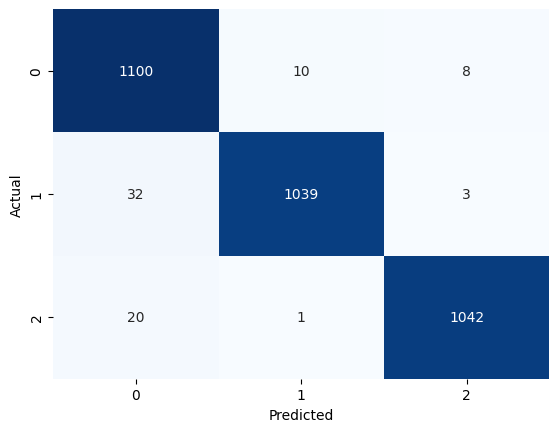

In [40]:
conf_matrix = confusion_matrix(actual, pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()